Reference: https://www.kaggle.com/code/ekaterinadranitsyna/segformer-water-segmentation-pytorch/notebook

In [ ]:
!pip install transformers datasets
!pip install --upgrade sympy
!pip install --upgrade datasets
!pip install evaluate
!pip install transformers
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 50.1 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Unin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

# ZIP 파일 경로
zip_path = "/content/drive/MyDrive/car_damage_data_v.zip"
output_dir = "/content/data"  # ZIP 파일을 풀 디렉토리
os.makedirs(output_dir, exist_ok=True)

# ZIP 파일 해제
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"ZIP 파일이 해제되었습니다: {output_dir}")

ZIP 파일이 해제되었습니다: /content/data


In [ ]:
# Split Sample Data Into train/valid/test
import os
import shutil
from sklearn.model_selection import train_test_split

# 경로 설정
base_dir = "/content/data/valid"
image_dir = "/content/data/valid/image"
label_dir = "/content/data/valid/label"
output_dir = "/content/sample_data/Split_data"
os.makedirs(output_dir, exist_ok = True)

# 출력 폴더 생성
for split in ["train", "valid", "test"]:
    os.makedirs(os.path.join(output_dir, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, split, "labels"), exist_ok=True)

# 이미지와 라벨 파일 가져오기
images = sorted(os.listdir(image_dir))
labels = sorted(os.listdir(label_dir))

# 이미지와 라벨 파일 매칭
print(len(images), len(labels))
assert len(images) == len(labels), "이미지와 라벨의 개수가 일치하지 않습니다."
data_pairs = list(zip(images, labels))

# 데이터를 7:1.5:1.5로 나누기
train_pairs, temp_pairs = train_test_split(data_pairs, test_size=0.3, random_state=42)
valid_pairs, test_pairs = train_test_split(temp_pairs, test_size=0.5, random_state=42)

# 데이터 분배 함수
def copy_files(pairs, split):
    for image_file, label_file in pairs:
        # 파일 경로 정의
        src_image_path = os.path.join(image_dir, image_file)
        src_label_path = os.path.join(label_dir, label_file)
        dest_image_path = os.path.join(output_dir, split, "images", image_file)
        dest_label_path = os.path.join(output_dir, split, "labels", label_file)

        # 파일 복사
        shutil.copy(src_image_path, dest_image_path)
        shutil.copy(src_label_path, dest_label_path)

# 파일 복사
copy_files(train_pairs, "train")
copy_files(valid_pairs, "valid")
copy_files(test_pairs, "test")

print("데이터가 성공적으로 분할되었습니다!")

10089 10089
데이터가 성공적으로 분할되었습니다!


In [ ]:
import os
import json
from PIL import Image, ImageDraw
from tqdm import tqdm  # 진행 상황 표시

# 데이터셋의 상위 디렉토리와 출력 디렉토리 설정
dataset_dir = "/content/sample_data/Split_data"
output_base_dir = "/content/data/masks"
os.makedirs(output_base_dir, exist_ok=True)

# 데이터셋의 train, valid, test 각각 처리
for split in ["train", "valid", "test"]:
    # JSON 파일이 있는 디렉토리
    json_dir = os.path.join(dataset_dir, split, "labels")
    if not os.path.exists(json_dir):
        print(f"{split} 디렉토리가 없습니다: {json_dir}")
        continue

    # 마스크 저장 디렉토리
    output_dir = os.path.join(output_base_dir, split)
    os.makedirs(output_dir, exist_ok=True)

    # JSON 디렉토리 순회
    for json_file in tqdm(os.listdir(json_dir), desc=f"Processing {split}"):
        if not json_file.endswith(".json"):
            continue  # JSON 파일만 처리

        # JSON 파일 경로
        json_path = os.path.join(json_dir, json_file)

        # JSON 데이터 로드
        with open(json_path, "r") as f:
            data = json.load(f)

        # 이미지 정보 가져오기
        image_info = data["images"]
        image_width, image_height = image_info["width"], image_info["height"]
        image_file = image_info["file_name"]

        # 빈 마스크 생성 (배경은 0으로 설정)
        mask = Image.new("L", (image_width, image_height), 0)  # "L"은 흑백 이미지를 의미
        draw = ImageDraw.Draw(mask)

        # 어노테이션 처리
        for ann in data["annotations"]:
            # "damage"가 있으면 1로 처리
            if "damage" in ann and ann["damage"] is not None:
                segmentation = ann["segmentation"][0][0]  # 다각형 좌표
                polygons = [tuple(point) for point in segmentation]  # (x, y) 튜플로 변환

                # "damage" 부분만 1로 표시
                draw.polygon(polygons, fill=1)  # damage 부분을 1로 채우기

        # 마스크 저장
        mask_output_path = os.path.join(output_dir, f"{os.path.splitext(image_file)[0]}_mask.png")
        mask.save(mask_output_path)

Processing test: 100%|██████████| 1514/1514 [00:08<00:00, 168.51it/s]


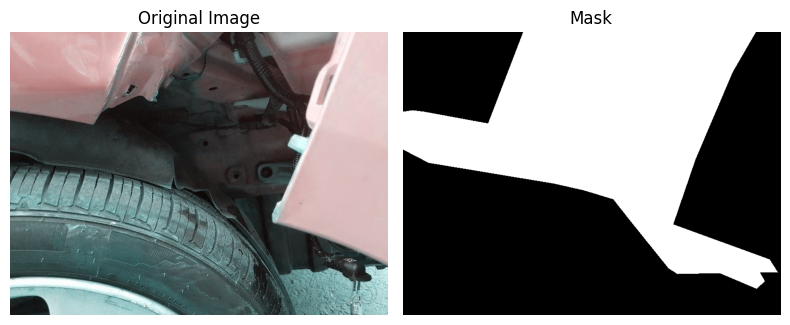

In [ ]:
# Mask Print
import matplotlib.pyplot as plt
import cv2

# 파일 경로 지정
imagefile = '/content/sample_data/Split_data/train/images/0506239_as-3483186.jpg'
maskfile = '/content/data/masks/train/0506239_as-3483186_mask.png'

# 이미지와 마스크 불러오기
image = cv2.imread(imagefile)  # 컬러 이미지
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR -> RGB 변환
mask = cv2.imread(maskfile, cv2.IMREAD_GRAYSCALE)  # Grayscale 마스크

# 이미지와 마스크 시각화
plt.figure(figsize=(8, 8))

# 원본 이미지 표시
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')  # 축 숨기기

# 마스크 이미지 표시
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')  # Grayscale로 표시
plt.title("Mask")
plt.axis('off')  # 축 숨기기

plt.tight_layout()  # 레이아웃 조정
plt.show()

In [ ]:
!pip install wandb
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
!pip install evaluate
import os
from datasets import Dataset
from transformers import TrainingArguments, Trainer
import torch
from PIL import Image
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

processor = SegformerImageProcessor()

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 경로 설정
train_images_dir = "/content/sample_data/Split_data/train/images"
train_masks_dir = "/content/data/masks/train"

val_images_dir = "/content/sample_data/Split_data/valid/images"
val_masks_dir = "/content/data/masks/valid"

# 배경 클래스 포함
label_mapping = {'Background': 0, 'Damaged': 1}

# id2label 및 label2id 생성
id2label = {v: k for k, v in label_mapping.items()}  # ID -> Label
label2id = {k: v for k, v in label_mapping.items()}  # Label -> ID

# 출력 확인
print("id2label:", id2label)
print("label2id:", label2id)

# 라벨 개수
num_labels = len(id2label)
print("Number of labels:", num_labels)

id2label: {0: 'Background', 1: 'Damaged'}
label2id: {'Background': 0, 'Damaged': 1}
Number of labels: 2


In [ ]:
# Model
import requests
import torch
from PIL import Image
from transformers import AutoImageProcessor, MobileViTV2ForSemanticSegmentation

model_name = "apple/mobilevitv2-1.0-imagenet1k-256"
processor = AutoImageProcessor.from_pretrained(model_name)
model = MobileViTV2ForSemanticSegmentation.from_pretrained(
    model_name,
    num_labels = 2,
    id2label=id2label,
    label2id=label2id

)

model.to(device)  # 모델을 GPU로 이동

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.8k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/19.8M [00:00<?, ?B/s]

Some weights of MobileViTV2ForSemanticSegmentation were not initialized from the model checkpoint at apple/mobilevitv2-1.0-imagenet1k-256 and are newly initialized: ['segmentation_head.aspp.convs.0.convolution.weight', 'segmentation_head.aspp.convs.0.normalization.bias', 'segmentation_head.aspp.convs.0.normalization.num_batches_tracked', 'segmentation_head.aspp.convs.0.normalization.running_mean', 'segmentation_head.aspp.convs.0.normalization.running_var', 'segmentation_head.aspp.convs.0.normalization.weight', 'segmentation_head.aspp.convs.1.convolution.weight', 'segmentation_head.aspp.convs.1.normalization.bias', 'segmentation_head.aspp.convs.1.normalization.num_batches_tracked', 'segmentation_head.aspp.convs.1.normalization.running_mean', 'segmentation_head.aspp.convs.1.normalization.running_var', 'segmentation_head.aspp.convs.1.normalization.weight', 'segmentation_head.aspp.convs.2.convolution.weight', 'segmentation_head.aspp.convs.2.normalization.bias', 'segmentation_head.aspp.conv

MobileViTV2ForSemanticSegmentation(
  (mobilevitv2): MobileViTV2Model(
    (conv_stem): MobileViTV2ConvLayer(
      (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (normalization): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU()
    )
    (encoder): MobileViTV2Encoder(
      (layer): ModuleList(
        (0): MobileViTV2MobileNetLayer(
          (layer): ModuleList(
            (0): MobileViTV2InvertedResidual(
              (expand_1x1): MobileViTV2ConvLayer(
                (convolution): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (activation): SiLU()
              )
              (conv_3x3): MobileViTV2ConvLayer(
                (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)


In [ ]:
# 총 파라미터 수 및 학습 가능한 파라미터 수 계산
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())  # 전체 파라미터 수
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)  # 학습 가능한 파라미터 수
    return total_params, trainable_params

# Conditional DETR 모델 로드 후 파라미터 수 계산
total_params, trainable_params = count_parameters(model)

print(f"Total Parameters: {total_params:,}")  # 천 단위 구분자로 표시
print(f"Trainable Parameters: {trainable_params:,}")


Total Parameters: 13,308,907
Trainable Parameters: 13,308,907


In [ ]:
processor

MobileViTImageProcessor {
  "crop_size": {
    "height": 256,
    "width": 256
  },
  "do_center_crop": true,
  "do_flip_channel_order": true,
  "do_rescale": true,
  "do_resize": true,
  "image_processor_type": "MobileViTImageProcessor",
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 288
  }
}

In [ ]:
# Load Dataset & Preprocessing

def load_data(images_dir, masks_dir):
    images = sorted(os.listdir(images_dir))
    masks = sorted(os.listdir(masks_dir))

    data = []
    for img_name, mask_name in zip(images, masks):
        image_path = os.path.join(images_dir, img_name)
        mask_path = os.path.join(masks_dir, mask_name)
        data.append({"image": image_path, "mask": mask_path})
    return data

train_data = load_data(train_images_dir, train_masks_dir)
val_data = load_data(val_images_dir, val_masks_dir)

# 데이터셋 준비
def preprocess(example):
    image = Image.open(example["image"]).convert("RGB").resize((512, 512))  # 512x512로 축소
    mask = Image.open(example["mask"]).resize((512, 512))
    encoding = processor(image, mask, return_tensors="pt")
    encoding = {k: v.squeeze(0).to(device) for k, v in encoding.items()}
    return encoding


train_dataset = Dataset.from_list(train_data).map(preprocess)
val_dataset = Dataset.from_list(val_data).map(preprocess)

Map:   0%|          | 0/7062 [00:00<?, ? examples/s]

Map:   0%|          | 0/1513 [00:00<?, ? examples/s]

In [ ]:
from datasets import Dataset
import os

# Google 드라이브 경로 설정
output_dir = "/content/drive/MyDrive/dataset_cache"

# 디렉토리 생성 (이미 있다면 무시)
os.makedirs(output_dir, exist_ok=True)

# 데이터셋 저장
train_dataset.save_to_disk(os.path.join(output_dir, "train_dataset"))
val_dataset.save_to_disk(os.path.join(output_dir, "val_dataset"))

print("Datasets saved to Google Drive!")


Saving the dataset (0/19 shards):   0%|          | 0/7062 [00:00<?, ? examples/s]

Saving the dataset (0/4 shards):   0%|          | 0/1513 [00:00<?, ? examples/s]

Datasets saved to Google Drive!


In [ ]:
# Evaluation Metrics
import torch
from torch import nn
import evaluate

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    pred_labels = logits_tensor.detach().cpu().numpy()
    metrics = metric.compute(
        predictions=pred_labels,
        references=labels,
        num_labels=len(id2label),
        ignore_index=None,
    )

    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    return metrics

In [ ]:
from transformers import TrainingArguments

epochs = 3
lr = 5e-5
batch_size = 4

training_args = TrainingArguments(
    "/content/mobilevitv2-finetuned--outputs",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=500,
    eval_steps=500,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
)

# Trainer 정의
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# 학습 시작
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: ksm030415 (ksm030415-sungkyunkwan-university). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Accuracy Background,Accuracy Damaged,Iou Background,Iou Damaged
500,0.209400,0.248871,0.509950,0.556439,0.908329,0.994019,0.118858,0.907250,0.112651
1000,0.412200,0.237139,0.544781,0.592562,0.912419,0.990308,0.194816,0.910716,0.178846
1500,0.190000,0.230800,0.532099,0.577847,0.912423,0.993897,0.161797,0.911014,0.153184
2000,0.207800,0.221203,0.571492,0.621559,0.915877,0.987547,0.255570,0.913718,0.229266
2500,0.266100,0.221943,0.573470,0.622699,0.916837,0.988464,0.256934,0.914691,0.232249
3000,0.139600,0.221617,0.562358,0.609084,0.916513,0.991376,0.226792,0.914617,0.210099
3500,0.429200,0.223246,0.549159,0.594437,0.915504,0.993688,0.195187,0.913858,0.184460
4000,0.159200,0.219169,0.570430,0.617262,0.917891,0.991098,0.243426,0.915886,0.224974
4500,0.169900,0.216726,0.569770,0.616667,0.917725,0.991036,0.242297,0.915726,0.223814
5000,0.135400,0.218910,0.573187,0.620480,0.918080,0.990549,0.250410,0.916021,0.230354


/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible 

TrainOutput(global_step=5298, training_loss=0.23904387403255636, metrics={'train_runtime': 6395.6983, 'train_samples_per_second': 3.313, 'train_steps_per_second': 0.828, 'total_flos': 3.326165035670569e+17, 'train_loss': 0.23904387403255636, 'epoch': 3.0})

In [ ]:
train_images_dir = "/content/sample_data/Split_data/train/images"
train_masks_dir = "/content/data/masks/train"

test_images_dir = '/content/sample_data/Split_data/test/images'
test_masks_dir = '/content/data/masks/test'
test_data = load_data(test_images_dir, test_masks_dir)
test_dataset = Dataset.from_list(test_data).map(preprocess)

# 테스트 평가
test_result = trainer.evaluate(eval_dataset=test_dataset)

# 테스트 결과 출력
print("Test Results:")
for key, value in test_result.items():
    print(f"{key}: {value}")

Map:   0%|          | 0/1514 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Test Results:
eval_loss: 0.22619828581809998
eval_mean_iou: 0.5583640116887623
eval_mean_accuracy: 0.6052652984212572
eval_overall_accuracy: 0.9149906858900264
eval_accuracy_Background: 0.991830735300967
eval_accuracy_Damaged: 0.21869986154154739
eval_iou_Background: 0.9131018525272311
eval_iou_Damaged: 0.20362617085029355
eval_runtime: 286.5984
eval_samples_per_second: 5.283
eval_steps_per_second: 1.322
epoch: 3.0


## Download

In [ ]:
import shutil

# 특정 체크포인트 디렉토리 경로
checkpoint_dir = "/content/mobilevitv2-finetuned--outputs/checkpoint-5000"

# 압축할 파일 이름과 경로
output_zip = "/content/checkpoint-5000.zip"

# 디렉토리를 압축
shutil.make_archive(output_zip.replace(".zip", ""), 'zip', checkpoint_dir)


'/content/checkpoint-5000.zip'

In [ ]:
from google.colab import files

# 압축된 체크포인트 다운로드
files.download(output_zip)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference

In [ ]:
ls /content/mobilevitv2-finetuned--outputs

checkpoint-4500/  checkpoint-5000/  checkpoint-5298/  runs/


In [ ]:
import os

# 각 체크포인트 디렉토리 내용 확인
print("Checkpoint 4500:")
print(os.listdir("/content/mobilevitv2-finetuned--outputs/checkpoint-4500/"))

print("Checkpoint 5000:")
print(os.listdir("/content/mobilevitv2-finetuned--outputs/checkpoint-5000/"))

print("Checkpoint 5298:")
print(os.listdir("/content/mobilevitv2-finetuned--outputs/checkpoint-5298/"))

Checkpoint 4500:
['scheduler.pt', 'rng_state.pth', 'optimizer.pt', 'config.json', 'model.safetensors', 'training_args.bin', 'trainer_state.json']
Checkpoint 5000:
['scheduler.pt', 'rng_state.pth', 'optimizer.pt', 'config.json', 'model.safetensors', 'training_args.bin', 'trainer_state.json']
Checkpoint 5298:
['scheduler.pt', 'rng_state.pth', 'optimizer.pt', 'config.json', 'model.safetensors', 'training_args.bin', 'trainer_state.json']


In [ ]:
!pip install safetensors
from safetensors.torch import load_file
import torch
from PIL import Image
import requests
from transformers import AutoImageProcessor, MobileViTV2ForSemanticSegmentation

# Model & Processor
model_name_inference = "/content/mobilevitv2-finetuned--outputs/checkpoint-5298/config.json"
processor_inference = AutoImageProcessor.from_pretrained("apple/mobilevitv2-1.0-imagenet1k-256")
model_weights_inference = load_file("/content/mobilevitv2-finetuned--outputs/checkpoint-5298/model.safetensors")
model_inference = MobileViTV2ForSemanticSegmentation.from_pretrained("apple/mobilevitv2-1.0-imagenet1k-256",
    config=model_name_inference)
model_inference.load_state_dict(model_weights_inference)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Inference
model_inference.eval()
model_inference.to(device)

Some weights of the model checkpoint at apple/mobilevitv2-1.0-imagenet1k-256 were not used when initializing MobileViTV2ForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing MobileViTV2ForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MobileViTV2ForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MobileViTV2ForSemanticSegmentation were not initialized from the model checkpoint at apple/mobilevitv2-1.0-imagenet1k-256 and are newly initialized: ['segmentation_head.aspp.convs.0.convolution.weight', 'segmentation_head.aspp.convs.0.normalization.bias', 'segmentation_head.aspp.convs.0.normali

MobileViTV2ForSemanticSegmentation(
  (mobilevitv2): MobileViTV2Model(
    (conv_stem): MobileViTV2ConvLayer(
      (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (normalization): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU()
    )
    (encoder): MobileViTV2Encoder(
      (layer): ModuleList(
        (0): MobileViTV2MobileNetLayer(
          (layer): ModuleList(
            (0): MobileViTV2InvertedResidual(
              (expand_1x1): MobileViTV2ConvLayer(
                (convolution): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (activation): SiLU()
              )
              (conv_3x3): MobileViTV2ConvLayer(
                (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)


In [ ]:
# Demo
image = Image.open("/content/drive/MyDrive/0569396_sc-208278.jpg").convert("RGB").resize((512, 512))  # 예시 이미지


inputs = processor(images=image, return_tensors="pt").to(device)


with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

print(f"logit shape : {logits.shape}")
predictions = torch.argmax(logits, dim=1).squeeze(0)
print(f"after prediction and squeezing, segmap shape: {predictions.shape}")

logit shape : torch.Size([1, 2, 8, 8])
after prediction and squeezing, segmap shape: torch.Size([8, 8])


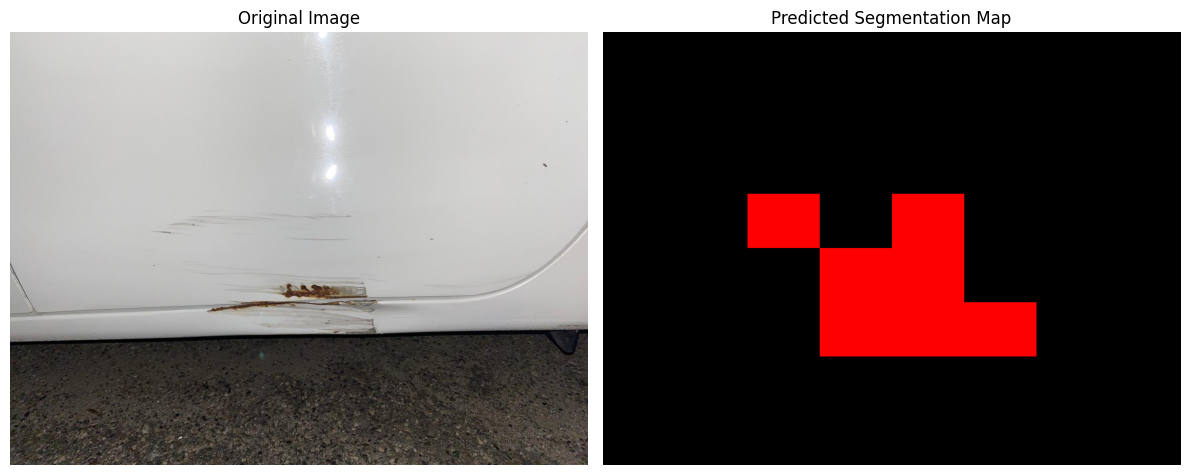

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

colors = [
    [0, 0, 0],      # Background
    [255, 0, 0]     # Damaged
]

image_path = "/content/drive/MyDrive/0569396_sc-208278.jpg"  # 원본 이미지 파일 경로

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictions = predictions.cpu().numpy()

# 세그멘테이션 맵을 색상으로 변환
colored_map = np.zeros((predictions.shape[0], predictions.shape[1], 3), dtype=np.uint8)
for class_id, color in enumerate(colors):
    colored_map[predictions == class_id] = color

colored_map_resized = cv2.resize(colored_map, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

plt.figure(figsize=(12, 12))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(colored_map_resized)
plt.title("Predicted Segmentation Map")
plt.axis("off")

plt.tight_layout()
plt.show()